# Multimodal analysis marker features significance calculation

Here we will use dual-omics SHARE-seq dataset, more specicially the dataset from figure4 in [SHARE-seq study](https://www.sciencedirect.com/science/article/abs/pii/S0092867420312538), "multiome_ma2020_fig4" as an example to illustrate how SIMBA performs marker feature significance calculation in multimodal analysis. Other analysis steps can be done as the same in "Multimodal analysis" tutorial.

In [1]:
import os
import simba as si
si.__version__

/srv/local/jayoung/conda/envs/jy_simba_copy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2'

In [9]:
workdir = 'result_multiome_shareseq_v5'
si.settings.set_workdir(workdir)

Saving results in: result_multiome_shareseq_v5


In [3]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [4]:
# to make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipykernel_24835/3381039072.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


### load example data

Following scripts download the scRNA-seq, scATAC-seq count matrices together with peak-TF motif/k-mer frequencies file. To generate the DNA sequence (TF motif & k-mer) frequency file by yourself, see https://simba-bio.readthedocs.io/en/latest/atac_buenrostro2018_peaks_and_sequences.html.


In [ ]:
dict_adata = si.datasets.multiome_ma2020_with_freqs()

multiome_ma2020_fig4_rna.h5ad: 43.7MB [00:30, 1.44MB/s]                              


Downloaded to result_multiome_shareseq_v5/data.


multiome_ma2020_fig4_atac.h5ad:  48%|████▊     | 137M/287M [01:27<01:50, 1.35MB/s]    

In [ ]:
adata_CP = dict_adata['atac']
adata_CG = dict_adata['rna']

## ATAC-seq part

### preprocessing

In [6]:
si.pp.filter_peaks(adata_CP,min_n_cells=3)

Before filtering: 
6436 cells, 344592 peaks
Filter peaks based on min_n_cells
After filtering out low-expressed peaks: 
6436 cells, 332987 peaks


In [7]:
si.pp.cal_qc_atac(adata_CP)

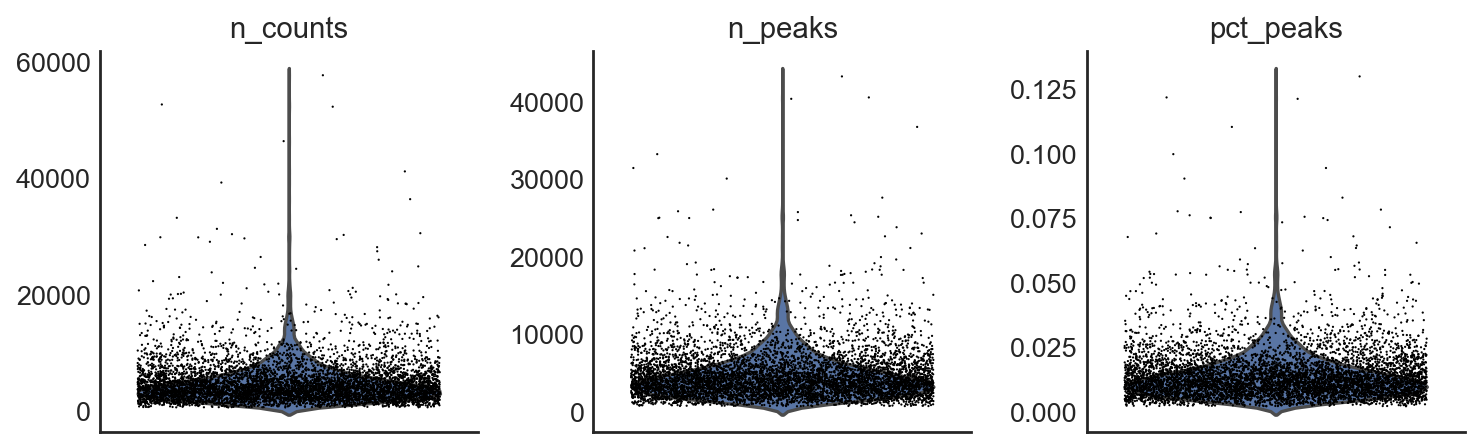

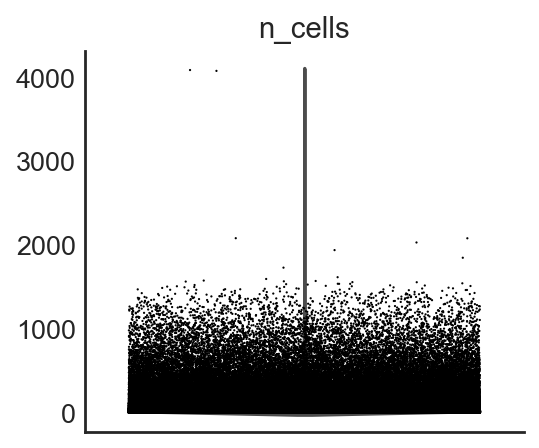

In [8]:
si.pl.violin(adata_CP,list_obs=['n_counts','n_peaks','pct_peaks'], list_var=['n_cells'])

select peaks (optional)  
It will speed up the trainning process by only keeping peaks associated with top PCs:

```python
si.pp.pca(adata_CP, n_components=40)
si.pl.pca_variance_ratio(adata_CP)
si.pp.select_pcs_features(adata_CP)
```

### select DNA sequences (Optional) 

In [6]:
adata_PK = si.read_hdf(os.path.join(workdir,'output_kmers_motifs/freq_kmer.h5'),'mat')
adata_PM = si.read_hdf(os.path.join(workdir,'output_kmers_motifs/freq_motif.h5'),'mat')

# convert byte string to string
adata_PK.obs.index = [x.decode('utf-8') for x in adata_PK.obs.index]
adata_PK.var.index = [x.decode('utf-8') for x in adata_PK.var.index]

adata_PM.obs.index = [x.decode('utf-8') for x in adata_PM.obs.index]
adata_PM.var.index = [x.decode('utf-8') for x in adata_PM.var.index]

In [ ]:
adata_CP

In [12]:
adata_PK

AnnData object with n_obs × n_vars = 332987 × 884

In [13]:
adata_PM

AnnData object with n_obs × n_vars = 332987 × 884

In [14]:
si.pp.binarize(adata_PK)
si.pp.binarize(adata_PM)

select kmers and motifs (optional)

```python
si.pp.pca(adata_PK, n_components=30)
si.pp.pca(adata_PM, n_components=30)
si.pp.select_pcs_features(adata_PK, min_elbow=adata_PK.shape[1]/5, S=5)
si.pp.select_pcs_features(adata_PM, min_elbow=adata_PM.shape[1]/5, S=5)
```

## RNA-seq part

### preprocessing

In [16]:
si.pp.filter_genes(adata_CG,min_n_cells=3)

Before filtering: 
6436 cells, 20331 genes
Filter genes based on min_n_cells
After filtering out low-expressed genes: 
6436 cells, 17399 genes


In [17]:
si.pp.cal_qc_rna(adata_CG)

In [18]:
si.pp.normalize(adata_CG,method='lib_size')

In [19]:
si.pp.log_transform(adata_CG)

Optionally, variable gene selection step can be also performed. 

```python
si.pp.select_variable_genes(adata_CG)
si.pl.variable_genes(adata_CG,show_texts=True)
```

This will speed up the training procedure as only variable genes are encoded into the graph. But we won't obtain the embeddings of non-variable genes.

### discretize RNA expression

In [20]:
si.tl.discretize(adata_CG, n_bins=5
                )

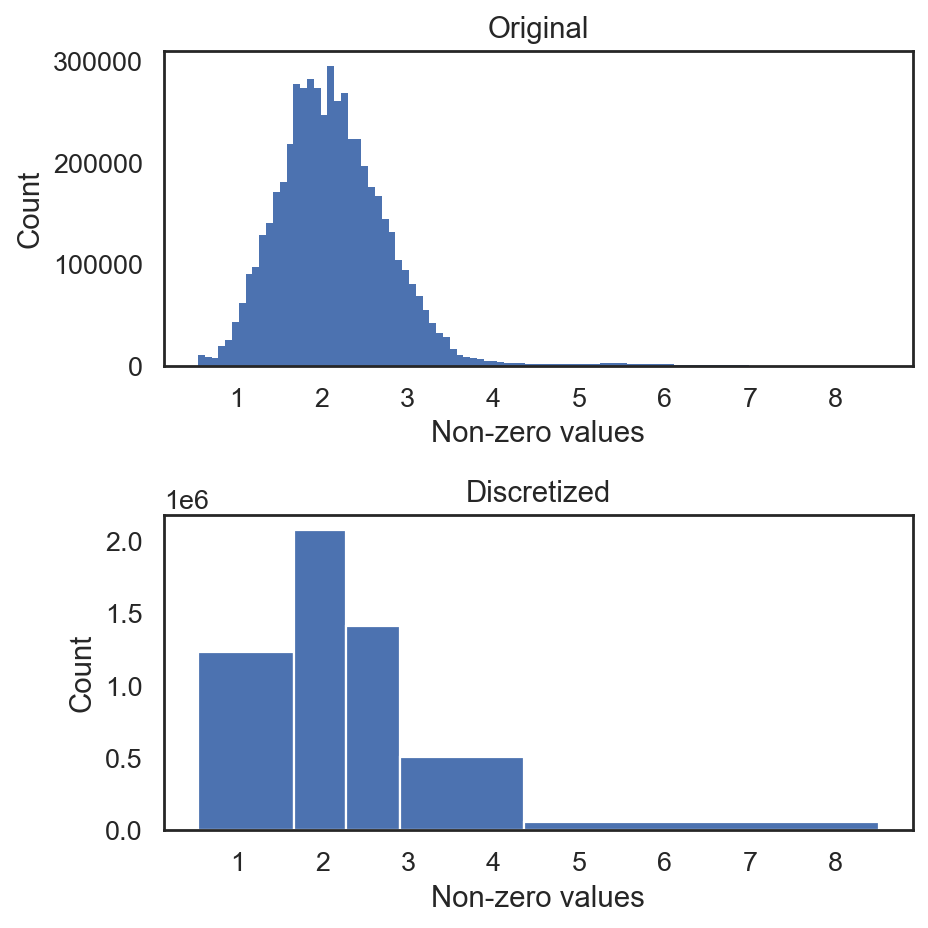

In [21]:
si.pl.discretize(adata_CG,kde=False)

### generate graph

In [22]:
si.tl.gen_graph(list_CP=[adata_CP],
                list_CG=[adata_CG],
                list_PK=[adata_PK],
                list_PM=[adata_PM],
                copy=False,
                use_highly_variable=False,
                use_top_pcs=False,
                dirname='graph_5',
               get_marker_significance=True,
               fold_null_nodes=5.0)

`simba` does not exist in anndata 0 in `list_CP`.`.X` is being used instead.
relation0: source: C, destination: P
#edges: 29715636
`simba` does not exist in anndata 0 in `list_PM`.`.X` is being used instead.
relation1: source: P, destination: M
#edges: 11851328
`simba` does not exist in anndata 0 in `list_PK`.`.X` is being used instead.
relation2: source: P, destination: K
#edges: 11851328
relation3: source: C, destination: G
#edges: 1230001
relation4: source: C, destination: G
#edges: 2077455
relation5: source: C, destination: G
#edges: 1413598
relation6: source: C, destination: G
#edges: 503387
relation7: source: C, destination: G
#edges: 57001
Total number of edges: 58699734
Writing graph file "pbg_graph.txt" to "result_multiome_shareseq_v5/pbg/graph_5" ...
Finished.
`simba` does not exist in anndata 0 in `list_CP`.`.X` is being used instead.
input graph: (6436, 332987)
relation0: source: C, destination: P
#edges: 29715636
relation1: source: nP, destination: C
#edges: 29715636
`simb

### PBG training

Before PBG training, let’s take a look at the parameters:

In [23]:
si.settings.pbg_params

{'entity_path': 'result_multiome_shareseq_v5/pbg/graph_5/input/entity',
 'edge_paths': ['result_multiome_shareseq_v5/pbg/graph_5/input/edge'],
 'checkpoint_path': '',
 'entities': {'C': {'num_partitions': 1},
  'G': {'num_partitions': 1},
  'P': {'num_partitions': 1},
  'K': {'num_partitions': 1},
  'M': {'num_partitions': 1},
  'nG': {'num_partitions': 1},
  'nP': {'num_partitions': 1},
  'nK': {'num_partitions': 1},
  'nM': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'P',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'P', 'rhs': 'M', 'operator': 'none', 'weight': 0.2},
  {'name': 'r2', 'lhs': 'P', 'rhs': 'K', 'operator': 'none', 'weight': 0.02},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 1.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r5', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r6', 'lhs': 'C', 'rhs': 'G', 'operator': 'none

If no parameters need to be adjusted, the training can be simply done with:

```python
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model')
```

Here we show how to adjust training-related parameters if needed. In general, weight decay `wd` is the only parameter that might need to be adjusted based on the following pbg metric plots. However, in almost all the cases, the automatically decided `wd` (enabling it by setting `auto_wd=True`) works well.

E.g. we want to change the number of cpus `workers`:

In [24]:
# modify parameters
dict_config = si.settings.pbg_params.copy()
# dict_config['wd'] = 0.000172
dict_config['workers'] = 12

## start training
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output='model', get_marker_significance=True)

Auto-estimated weight decay is 4.027513E-04
`.settings.pbg_params['wd']` has been updated to 4.027513E-04
Converting input data ...
[2022-11-28 11:38:54.629939] Using the 8 relation types given in the config
[2022-11-28 11:38:54.630393] Searching for the entities in the edge files...
[2022-11-28 11:40:05.394930] Entity type C:
[2022-11-28 11:40:05.396357] - Found 6436 entities
[2022-11-28 11:40:05.396842] - Removing the ones with fewer than 1 occurrences...
[2022-11-28 11:40:05.398525] - Left with 6436 entities
[2022-11-28 11:40:05.398880] - Shuffling them...
[2022-11-28 11:40:05.402765] Entity type G:
[2022-11-28 11:40:05.403108] - Found 17399 entities
[2022-11-28 11:40:05.403529] - Removing the ones with fewer than 1 occurrences...
[2022-11-28 11:40:05.406069] - Left with 17399 entities
[2022-11-28 11:40:05.407071] - Shuffling them...
[2022-11-28 11:40:05.416138] Entity type P:
[2022-11-28 11:40:05.416457] - Found 332987 entities
[2022-11-28 11:40:05.416961] - Removing the ones with 

[2022-11-28 11:40:35.249580] - Processed 6800000 edges so far...
[2022-11-28 11:40:35.661312] - Processed 6900000 edges so far...
[2022-11-28 11:40:36.071248] - Processed 7000000 edges so far...
[2022-11-28 11:40:36.482293] - Processed 7100000 edges so far...
[2022-11-28 11:40:36.893496] - Processed 7200000 edges so far...
[2022-11-28 11:40:37.304521] - Processed 7300000 edges so far...
[2022-11-28 11:40:37.714204] - Processed 7400000 edges so far...
[2022-11-28 11:40:38.126154] - Processed 7500000 edges so far...
[2022-11-28 11:40:38.536474] - Processed 7600000 edges so far...
[2022-11-28 11:40:38.947332] - Processed 7700000 edges so far...
[2022-11-28 11:40:39.361025] - Processed 7800000 edges so far...
[2022-11-28 11:40:39.773643] - Processed 7900000 edges so far...
[2022-11-28 11:40:40.185218] - Processed 8000000 edges so far...
[2022-11-28 11:40:40.594950] - Processed 8100000 edges so far...
[2022-11-28 11:40:41.005240] - Processed 8200000 edges so far...
[2022-11-28 11:40:41.4170

[2022-11-28 11:41:26.594185] - Processed 19300000 edges so far...
[2022-11-28 11:41:27.002784] - Processed 19400000 edges so far...
[2022-11-28 11:41:27.410949] - Processed 19500000 edges so far...
[2022-11-28 11:41:27.819919] - Processed 19600000 edges so far...
[2022-11-28 11:41:28.230530] - Processed 19700000 edges so far...
[2022-11-28 11:41:28.640181] - Processed 19800000 edges so far...
[2022-11-28 11:41:29.049196] - Processed 19900000 edges so far...
[2022-11-28 11:41:29.457200] - Processed 20000000 edges so far...
[2022-11-28 11:41:29.865693] - Processed 20100000 edges so far...
[2022-11-28 11:41:30.272856] - Processed 20200000 edges so far...
[2022-11-28 11:41:30.679993] - Processed 20300000 edges so far...
[2022-11-28 11:41:31.087544] - Processed 20400000 edges so far...
[2022-11-28 11:41:31.495130] - Processed 20500000 edges so far...
[2022-11-28 11:41:31.904095] - Processed 20600000 edges so far...
[2022-11-28 11:41:32.311735] - Processed 20700000 edges so far...
[2022-11-2

[2022-11-28 11:42:17.549187] - Processed 31800000 edges so far...
[2022-11-28 11:42:17.944739] - Processed 31900000 edges so far...
[2022-11-28 11:42:18.339317] - Processed 32000000 edges so far...
[2022-11-28 11:42:18.734551] - Processed 32100000 edges so far...
[2022-11-28 11:42:19.135300] - Processed 32200000 edges so far...
[2022-11-28 11:42:19.534652] - Processed 32300000 edges so far...
[2022-11-28 11:42:19.932580] - Processed 32400000 edges so far...
[2022-11-28 11:42:20.327591] - Processed 32500000 edges so far...
[2022-11-28 11:42:20.723061] - Processed 32600000 edges so far...
[2022-11-28 11:42:21.119229] - Processed 32700000 edges so far...
[2022-11-28 11:42:21.514376] - Processed 32800000 edges so far...
[2022-11-28 11:42:21.910603] - Processed 32900000 edges so far...
[2022-11-28 11:42:22.309135] - Processed 33000000 edges so far...
[2022-11-28 11:42:22.704316] - Processed 33100000 edges so far...
[2022-11-28 11:42:23.101055] - Processed 33200000 edges so far...
[2022-11-2

[2022-11-28 11:43:06.881373] - Processed 44300000 edges so far...
[2022-11-28 11:43:07.276270] - Processed 44400000 edges so far...
[2022-11-28 11:43:07.671652] - Processed 44500000 edges so far...
[2022-11-28 11:43:08.068510] - Processed 44600000 edges so far...
[2022-11-28 11:43:08.478086] - Processed 44700000 edges so far...
[2022-11-28 11:43:08.876277] - Processed 44800000 edges so far...
[2022-11-28 11:43:09.272100] - Processed 44900000 edges so far...
[2022-11-28 11:43:09.667568] - Processed 45000000 edges so far...
[2022-11-28 11:43:10.062510] - Processed 45100000 edges so far...
[2022-11-28 11:43:10.456299] - Processed 45200000 edges so far...
[2022-11-28 11:43:10.849105] - Processed 45300000 edges so far...
[2022-11-28 11:43:11.244353] - Processed 45400000 edges so far...
[2022-11-28 11:43:11.638440] - Processed 45500000 edges so far...
[2022-11-28 11:43:12.034511] - Processed 45600000 edges so far...
[2022-11-28 11:43:12.429975] - Processed 45700000 edges so far...
[2022-11-2

[2022-11-28 11:43:56.422444] - Processed 56800000 edges so far...
[2022-11-28 11:43:56.820149] - Processed 56900000 edges so far...
[2022-11-28 11:43:57.219029] - Processed 57000000 edges so far...
[2022-11-28 11:43:57.625607] - Processed 57100000 edges so far...
[2022-11-28 11:43:58.025243] - Processed 57200000 edges so far...
[2022-11-28 11:43:58.423449] - Processed 57300000 edges so far...
[2022-11-28 11:43:58.821673] - Processed 57400000 edges so far...
[2022-11-28 11:43:59.219208] - Processed 57500000 edges so far...
[2022-11-28 11:43:59.618858] - Processed 57600000 edges so far...
[2022-11-28 11:44:00.018872] - Processed 57700000 edges so far...
[2022-11-28 11:44:00.417745] - Processed 57800000 edges so far...
[2022-11-28 11:44:00.817406] - Processed 57900000 edges so far...
[2022-11-28 11:44:01.220378] - Processed 58000000 edges so far...
[2022-11-28 11:44:01.619969] - Processed 58100000 edges so far...
[2022-11-28 11:44:02.018186] - Processed 58200000 edges so far...
[2022-11-2

[2022-11-28 12:08:38.476939] - Processed 4900000 edges so far...
[2022-11-28 12:08:38.889828] - Processed 5000000 edges so far...
[2022-11-28 12:08:39.301718] - Processed 5100000 edges so far...
[2022-11-28 12:08:39.714589] - Processed 5200000 edges so far...
[2022-11-28 12:08:40.128387] - Processed 5300000 edges so far...
[2022-11-28 12:08:40.543158] - Processed 5400000 edges so far...
[2022-11-28 12:08:40.957621] - Processed 5500000 edges so far...
[2022-11-28 12:08:41.371270] - Processed 5600000 edges so far...
[2022-11-28 12:08:41.785892] - Processed 5700000 edges so far...
[2022-11-28 12:08:42.198182] - Processed 5800000 edges so far...
[2022-11-28 12:08:42.610411] - Processed 5900000 edges so far...
[2022-11-28 12:08:43.022319] - Processed 6000000 edges so far...
[2022-11-28 12:08:43.433351] - Processed 6100000 edges so far...
[2022-11-28 12:08:43.846468] - Processed 6200000 edges so far...
[2022-11-28 12:08:44.270678] - Processed 6300000 edges so far...
[2022-11-28 12:08:44.6817

[2022-11-28 12:09:29.875150] - Processed 17400000 edges so far...
[2022-11-28 12:09:30.284701] - Processed 17500000 edges so far...
[2022-11-28 12:09:30.693357] - Processed 17600000 edges so far...
[2022-11-28 12:09:31.101935] - Processed 17700000 edges so far...
[2022-11-28 12:09:31.510159] - Processed 17800000 edges so far...
[2022-11-28 12:09:31.918630] - Processed 17900000 edges so far...
[2022-11-28 12:09:32.327064] - Processed 18000000 edges so far...
[2022-11-28 12:09:32.736913] - Processed 18100000 edges so far...
[2022-11-28 12:09:33.145319] - Processed 18200000 edges so far...
[2022-11-28 12:09:33.555156] - Processed 18300000 edges so far...
[2022-11-28 12:09:33.965593] - Processed 18400000 edges so far...
[2022-11-28 12:09:34.374462] - Processed 18500000 edges so far...
[2022-11-28 12:09:34.784712] - Processed 18600000 edges so far...
[2022-11-28 12:09:35.193376] - Processed 18700000 edges so far...
[2022-11-28 12:09:35.604074] - Processed 18800000 edges so far...
[2022-11-2

[2022-11-28 12:10:21.143709] - Processed 29900000 edges so far...
[2022-11-28 12:10:21.547785] - Processed 30000000 edges so far...
[2022-11-28 12:10:21.949263] - Processed 30100000 edges so far...
[2022-11-28 12:10:22.353176] - Processed 30200000 edges so far...
[2022-11-28 12:10:22.757374] - Processed 30300000 edges so far...
[2022-11-28 12:10:23.160908] - Processed 30400000 edges so far...
[2022-11-28 12:10:23.564139] - Processed 30500000 edges so far...
[2022-11-28 12:10:23.964823] - Processed 30600000 edges so far...
[2022-11-28 12:10:24.367617] - Processed 30700000 edges so far...
[2022-11-28 12:10:24.770843] - Processed 30800000 edges so far...
[2022-11-28 12:10:25.172610] - Processed 30900000 edges so far...
[2022-11-28 12:10:25.577072] - Processed 31000000 edges so far...
[2022-11-28 12:10:25.978171] - Processed 31100000 edges so far...
[2022-11-28 12:10:26.379910] - Processed 31200000 edges so far...
[2022-11-28 12:10:26.782553] - Processed 31300000 edges so far...
[2022-11-2

[2022-11-28 12:11:11.757286] - Processed 42400000 edges so far...
[2022-11-28 12:11:12.160810] - Processed 42500000 edges so far...
[2022-11-28 12:11:12.564292] - Processed 42600000 edges so far...
[2022-11-28 12:11:12.968688] - Processed 42700000 edges so far...
[2022-11-28 12:11:13.372390] - Processed 42800000 edges so far...
[2022-11-28 12:11:13.779794] - Processed 42900000 edges so far...
[2022-11-28 12:11:14.185326] - Processed 43000000 edges so far...
[2022-11-28 12:11:14.587710] - Processed 43100000 edges so far...
[2022-11-28 12:11:14.991932] - Processed 43200000 edges so far...
[2022-11-28 12:11:15.397525] - Processed 43300000 edges so far...
[2022-11-28 12:11:15.806087] - Processed 43400000 edges so far...
[2022-11-28 12:11:16.210469] - Processed 43500000 edges so far...
[2022-11-28 12:11:16.615866] - Processed 43600000 edges so far...
[2022-11-28 12:11:17.020485] - Processed 43700000 edges so far...
[2022-11-28 12:11:17.423830] - Processed 43800000 edges so far...
[2022-11-2

[2022-11-28 12:12:02.445119] - Processed 54900000 edges so far...
[2022-11-28 12:12:02.850334] - Processed 55000000 edges so far...
[2022-11-28 12:12:03.258089] - Processed 55100000 edges so far...
[2022-11-28 12:12:03.662197] - Processed 55200000 edges so far...
[2022-11-28 12:12:04.068132] - Processed 55300000 edges so far...
[2022-11-28 12:12:04.474491] - Processed 55400000 edges so far...
[2022-11-28 12:12:04.882719] - Processed 55500000 edges so far...
[2022-11-28 12:12:05.289798] - Processed 55600000 edges so far...
[2022-11-28 12:12:05.697213] - Processed 55700000 edges so far...
[2022-11-28 12:12:06.103120] - Processed 55800000 edges so far...
[2022-11-28 12:12:06.512774] - Processed 55900000 edges so far...
[2022-11-28 12:12:06.917006] - Processed 56000000 edges so far...
[2022-11-28 12:12:07.322455] - Processed 56100000 edges so far...
[2022-11-28 12:12:07.727074] - Processed 56200000 edges so far...
[2022-11-28 12:12:08.137550] - Processed 56300000 edges so far...
[2022-11-2

[2022-11-28 12:12:52.937775] - Processed 67400000 edges so far...
[2022-11-28 12:12:53.332811] - Processed 67500000 edges so far...
[2022-11-28 12:12:53.733416] - Processed 67600000 edges so far...
[2022-11-28 12:12:54.128524] - Processed 67700000 edges so far...
[2022-11-28 12:12:54.520803] - Processed 67800000 edges so far...
[2022-11-28 12:12:54.918674] - Processed 67900000 edges so far...
[2022-11-28 12:12:55.313738] - Processed 68000000 edges so far...
[2022-11-28 12:12:55.711724] - Processed 68100000 edges so far...
[2022-11-28 12:12:56.108375] - Processed 68200000 edges so far...
[2022-11-28 12:12:56.502999] - Processed 68300000 edges so far...
[2022-11-28 12:12:56.900918] - Processed 68400000 edges so far...
[2022-11-28 12:12:57.298364] - Processed 68500000 edges so far...
[2022-11-28 12:12:57.693641] - Processed 68600000 edges so far...
[2022-11-28 12:12:58.094408] - Processed 68700000 edges so far...
[2022-11-28 12:12:58.490631] - Processed 68800000 edges so far...
[2022-11-2

[2022-11-28 12:13:44.576696] - Processed 79900000 edges so far...
[2022-11-28 12:13:44.994080] - Processed 80000000 edges so far...
[2022-11-28 12:13:45.414786] - Processed 80100000 edges so far...
[2022-11-28 12:13:45.832876] - Processed 80200000 edges so far...
[2022-11-28 12:13:46.248004] - Processed 80300000 edges so far...
[2022-11-28 12:13:46.669042] - Processed 80400000 edges so far...
[2022-11-28 12:13:47.086317] - Processed 80500000 edges so far...
[2022-11-28 12:13:47.505592] - Processed 80600000 edges so far...
[2022-11-28 12:13:47.925559] - Processed 80700000 edges so far...
[2022-11-28 12:13:48.339885] - Processed 80800000 edges so far...
[2022-11-28 12:13:48.760451] - Processed 80900000 edges so far...
[2022-11-28 12:13:49.179971] - Processed 81000000 edges so far...
[2022-11-28 12:13:49.595476] - Processed 81100000 edges so far...
[2022-11-28 12:13:50.014085] - Processed 81200000 edges so far...
[2022-11-28 12:13:50.433481] - Processed 81300000 edges so far...
[2022-11-2

[2022-11-28 12:14:37.021426] - Processed 92400000 edges so far...
[2022-11-28 12:14:37.439819] - Processed 92500000 edges so far...
[2022-11-28 12:14:37.859499] - Processed 92600000 edges so far...
[2022-11-28 12:14:38.274202] - Processed 92700000 edges so far...
[2022-11-28 12:14:38.696032] - Processed 92800000 edges so far...
[2022-11-28 12:14:39.118250] - Processed 92900000 edges so far...
[2022-11-28 12:14:39.534540] - Processed 93000000 edges so far...
[2022-11-28 12:14:39.950748] - Processed 93100000 edges so far...
[2022-11-28 12:14:40.370308] - Processed 93200000 edges so far...
[2022-11-28 12:14:40.787647] - Processed 93300000 edges so far...
[2022-11-28 12:14:41.210408] - Processed 93400000 edges so far...
[2022-11-28 12:14:41.629551] - Processed 93500000 edges so far...
[2022-11-28 12:14:42.045936] - Processed 93600000 edges so far...
[2022-11-28 12:14:42.464315] - Processed 93700000 edges so far...
[2022-11-28 12:14:42.881584] - Processed 93800000 edges so far...
[2022-11-2

[2022-11-28 12:15:29.121152] - Processed 104800000 edges so far...
[2022-11-28 12:15:29.532279] - Processed 104900000 edges so far...
[2022-11-28 12:15:29.948762] - Processed 105000000 edges so far...
[2022-11-28 12:15:30.374551] - Processed 105100000 edges so far...
[2022-11-28 12:15:30.793405] - Processed 105200000 edges so far...
[2022-11-28 12:15:31.220212] - Processed 105300000 edges so far...
[2022-11-28 12:15:31.641718] - Processed 105400000 edges so far...
[2022-11-28 12:15:32.059458] - Processed 105500000 edges so far...
[2022-11-28 12:15:32.483023] - Processed 105600000 edges so far...
[2022-11-28 12:15:32.904055] - Processed 105700000 edges so far...
[2022-11-28 12:15:33.328550] - Processed 105800000 edges so far...
[2022-11-28 12:15:33.747501] - Processed 105900000 edges so far...
[2022-11-28 12:15:34.162215] - Processed 106000000 edges so far...
[2022-11-28 12:15:34.584528] - Processed 106100000 edges so far...
[2022-11-28 12:15:35.004923] - Processed 106200000 edges so fa

[2022-11-28 12:16:20.661286] - Processed 117100000 edges so far...
[2022-11-28 12:16:21.081589] - Processed 117200000 edges so far...
[2022-11-28 12:16:21.498283] - Processed 117300000 edges so far...
[2022-11-28 12:16:21.921211] - Processed 117400000 edges so far...
[2022-11-28 12:16:22.339868] - Processed 117500000 edges so far...
[2022-11-28 12:16:22.760840] - Processed 117600000 edges so far...
[2022-11-28 12:16:23.176738] - Processed 117700000 edges so far...
[2022-11-28 12:16:23.593532] - Processed 117800000 edges so far...
[2022-11-28 12:16:24.004548] - Processed 117900000 edges so far...
[2022-11-28 12:16:24.428419] - Processed 118000000 edges so far...
[2022-11-28 12:16:24.842741] - Processed 118100000 edges so far...
[2022-11-28 12:16:25.266642] - Processed 118200000 edges so far...
[2022-11-28 12:16:25.683591] - Processed 118300000 edges so far...
[2022-11-28 12:16:26.106985] - Processed 118400000 edges so far...
[2022-11-28 12:16:26.523205] - Processed 118500000 edges so fa

[2022-11-28 12:17:12.182481] - Processed 129400000 edges so far...
[2022-11-28 12:17:12.599155] - Processed 129500000 edges so far...
[2022-11-28 12:17:13.022373] - Processed 129600000 edges so far...
[2022-11-28 12:17:13.437665] - Processed 129700000 edges so far...
[2022-11-28 12:17:13.856933] - Processed 129800000 edges so far...
[2022-11-28 12:17:14.280518] - Processed 129900000 edges so far...
[2022-11-28 12:17:14.696478] - Processed 130000000 edges so far...
[2022-11-28 12:17:15.117573] - Processed 130100000 edges so far...
[2022-11-28 12:17:15.532623] - Processed 130200000 edges so far...
[2022-11-28 12:17:15.960592] - Processed 130300000 edges so far...
[2022-11-28 12:17:16.379636] - Processed 130400000 edges so far...
[2022-11-28 12:17:16.795207] - Processed 130500000 edges so far...
[2022-11-28 12:17:17.199731] - Processed 130600000 edges so far...
[2022-11-28 12:17:17.595100] - Processed 130700000 edges so far...
[2022-11-28 12:17:17.988799] - Processed 130800000 edges so fa

[2022-11-28 12:18:01.489830] - Processed 141700000 edges so far...
[2022-11-28 12:18:01.886732] - Processed 141800000 edges so far...
[2022-11-28 12:18:02.290969] - Processed 141900000 edges so far...
[2022-11-28 12:18:02.688122] - Processed 142000000 edges so far...
[2022-11-28 12:18:03.084624] - Processed 142100000 edges so far...
[2022-11-28 12:18:03.488497] - Processed 142200000 edges so far...
[2022-11-28 12:18:03.883832] - Processed 142300000 edges so far...
[2022-11-28 12:18:04.286682] - Processed 142400000 edges so far...
[2022-11-28 12:18:04.704572] - Processed 142500000 edges so far...
[2022-11-28 12:18:05.126785] - Processed 142600000 edges so far...
[2022-11-28 12:18:05.542801] - Processed 142700000 edges so far...
[2022-11-28 12:18:05.960517] - Processed 142800000 edges so far...
[2022-11-28 12:18:06.373806] - Processed 142900000 edges so far...
[2022-11-28 12:18:06.794740] - Processed 143000000 edges so far...
[2022-11-28 12:18:07.208164] - Processed 143100000 edges so fa

[2022-11-28 12:18:52.938667] - Processed 154000000 edges so far...
[2022-11-28 12:18:53.355418] - Processed 154100000 edges so far...
[2022-11-28 12:18:53.782039] - Processed 154200000 edges so far...
[2022-11-28 12:18:54.197659] - Processed 154300000 edges so far...
[2022-11-28 12:18:54.619244] - Processed 154400000 edges so far...
[2022-11-28 12:18:55.034480] - Processed 154500000 edges so far...
[2022-11-28 12:18:55.454437] - Processed 154600000 edges so far...
[2022-11-28 12:18:55.868378] - Processed 154700000 edges so far...
[2022-11-28 12:18:56.284956] - Processed 154800000 edges so far...
[2022-11-28 12:18:56.697756] - Processed 154900000 edges so far...
[2022-11-28 12:18:57.118964] - Processed 155000000 edges so far...
[2022-11-28 12:18:57.533882] - Processed 155100000 edges so far...
[2022-11-28 12:18:57.954052] - Processed 155200000 edges so far...
[2022-11-28 12:18:58.371167] - Processed 155300000 edges so far...
[2022-11-28 12:18:58.792820] - Processed 155400000 edges so fa

[2022-11-28 12:19:44.785383] - Processed 166300000 edges so far...
[2022-11-28 12:19:45.206833] - Processed 166400000 edges so far...
[2022-11-28 12:19:45.623410] - Processed 166500000 edges so far...
[2022-11-28 12:19:46.045170] - Processed 166600000 edges so far...
[2022-11-28 12:19:46.460299] - Processed 166700000 edges so far...
[2022-11-28 12:19:46.878650] - Processed 166800000 edges so far...
[2022-11-28 12:19:47.301021] - Processed 166900000 edges so far...
[2022-11-28 12:19:47.717599] - Processed 167000000 edges so far...
[2022-11-28 12:19:48.139644] - Processed 167100000 edges so far...
[2022-11-28 12:19:48.556237] - Processed 167200000 edges so far...
[2022-11-28 12:19:48.981737] - Processed 167300000 edges so far...
[2022-11-28 12:19:49.396588] - Processed 167400000 edges so far...
[2022-11-28 12:19:49.824897] - Processed 167500000 edges so far...
[2022-11-28 12:19:50.243189] - Processed 167600000 edges so far...
[2022-11-28 12:19:50.659259] - Processed 167700000 edges so fa

[2022-11-28 12:20:36.963252] - Processed 178600000 edges so far...
[2022-11-28 12:20:37.384360] - Processed 178700000 edges so far...
[2022-11-28 12:20:37.798153] - Processed 178800000 edges so far...
[2022-11-28 12:20:38.218265] - Processed 178900000 edges so far...
[2022-11-28 12:20:38.641465] - Processed 179000000 edges so far...
[2022-11-28 12:20:39.058216] - Processed 179100000 edges so far...
[2022-11-28 12:20:39.481133] - Processed 179200000 edges so far...
[2022-11-28 12:20:39.898737] - Processed 179300000 edges so far...
[2022-11-28 12:20:40.321073] - Processed 179400000 edges so far...
[2022-11-28 12:20:40.740119] - Processed 179500000 edges so far...
[2022-11-28 12:20:41.171772] - Processed 179600000 edges so far...
[2022-11-28 12:20:41.590470] - Processed 179700000 edges so far...
[2022-11-28 12:20:42.009356] - Processed 179800000 edges so far...
[2022-11-28 12:20:42.428302] - Processed 179900000 edges so far...
[2022-11-28 12:20:42.851813] - Processed 180000000 edges so fa

[2022-11-28 12:21:29.102220] - Processed 190900000 edges so far...
[2022-11-28 12:21:29.531598] - Processed 191000000 edges so far...
[2022-11-28 12:21:29.950417] - Processed 191100000 edges so far...
[2022-11-28 12:21:30.366812] - Processed 191200000 edges so far...
[2022-11-28 12:21:30.784867] - Processed 191300000 edges so far...
[2022-11-28 12:21:31.205456] - Processed 191400000 edges so far...
[2022-11-28 12:21:31.626179] - Processed 191500000 edges so far...
[2022-11-28 12:21:32.046701] - Processed 191600000 edges so far...
[2022-11-28 12:21:32.474541] - Processed 191700000 edges so far...
[2022-11-28 12:21:32.895340] - Processed 191800000 edges so far...
[2022-11-28 12:21:33.316248] - Processed 191900000 edges so far...
[2022-11-28 12:21:33.736447] - Processed 192000000 edges so far...
[2022-11-28 12:21:34.157012] - Processed 192100000 edges so far...
[2022-11-28 12:21:34.588247] - Processed 192200000 edges so far...
[2022-11-28 12:21:35.009895] - Processed 192300000 edges so fa

[2022-11-28 12:22:20.815500] - Processed 203200000 edges so far...
[2022-11-28 12:22:21.223232] - Processed 203300000 edges so far...
[2022-11-28 12:22:21.624043] - Processed 203400000 edges so far...
[2022-11-28 12:22:22.035286] - Processed 203500000 edges so far...
[2022-11-28 12:22:22.438859] - Processed 203600000 edges so far...
[2022-11-28 12:22:22.857661] - Processed 203700000 edges so far...
[2022-11-28 12:22:23.262032] - Processed 203800000 edges so far...
[2022-11-28 12:22:23.668888] - Processed 203900000 edges so far...
[2022-11-28 12:22:24.090348] - Processed 204000000 edges so far...
[2022-11-28 12:22:24.494575] - Processed 204100000 edges so far...
[2022-11-28 12:22:24.898508] - Processed 204200000 edges so far...
[2022-11-28 12:22:25.319558] - Processed 204300000 edges so far...
[2022-11-28 12:22:25.723982] - Processed 204400000 edges so far...
[2022-11-28 12:22:26.144907] - Processed 204500000 edges so far...
[2022-11-28 12:22:26.550045] - Processed 204600000 edges so fa

[2022-11-28 12:23:11.001577] - Processed 215500000 edges so far...
[2022-11-28 12:23:11.412773] - Processed 215600000 edges so far...
[2022-11-28 12:23:11.820017] - Processed 215700000 edges so far...
[2022-11-28 12:23:12.226719] - Processed 215800000 edges so far...
[2022-11-28 12:23:12.650182] - Processed 215900000 edges so far...
[2022-11-28 12:23:13.054493] - Processed 216000000 edges so far...
[2022-11-28 12:23:13.457990] - Processed 216100000 edges so far...
[2022-11-28 12:23:13.877771] - Processed 216200000 edges so far...
[2022-11-28 12:23:14.281087] - Processed 216300000 edges so far...
[2022-11-28 12:23:14.700597] - Processed 216400000 edges so far...
[2022-11-28 12:23:15.103759] - Processed 216500000 edges so far...
[2022-11-28 12:23:15.522843] - Processed 216600000 edges so far...
[2022-11-28 12:23:15.926084] - Processed 216700000 edges so far...
[2022-11-28 12:23:16.329484] - Processed 216800000 edges so far...
[2022-11-28 12:23:16.748768] - Processed 216900000 edges so fa

[2022-11-28 12:24:01.205852] - Processed 227800000 edges so far...
[2022-11-28 12:24:01.608841] - Processed 227900000 edges so far...
[2022-11-28 12:24:02.029122] - Processed 228000000 edges so far...
[2022-11-28 12:24:02.431031] - Processed 228100000 edges so far...
[2022-11-28 12:24:02.851512] - Processed 228200000 edges so far...
[2022-11-28 12:24:03.254630] - Processed 228300000 edges so far...
[2022-11-28 12:24:03.656858] - Processed 228400000 edges so far...
[2022-11-28 12:24:04.075730] - Processed 228500000 edges so far...
[2022-11-28 12:24:04.478464] - Processed 228600000 edges so far...
[2022-11-28 12:24:04.898961] - Processed 228700000 edges so far...
[2022-11-28 12:24:05.303758] - Processed 228800000 edges so far...
[2022-11-28 12:24:05.708064] - Processed 228900000 edges so far...
[2022-11-28 12:24:06.122837] - Processed 229000000 edges so far...
[2022-11-28 12:24:06.526089] - Processed 229100000 edges so far...
[2022-11-28 12:24:06.953330] - Processed 229200000 edges so fa

> If `wd` is specified by users instead of being automatically decided, then make sure to update it in simba setting:
```python
si.settings.pbg_params = dict_config.copy()
```

The trained result can be loaded in with the following steps:

By default, it's using the current training result stored in `.setting.pbg_params`
```python
# load in graph ('graph0') info
si.load_graph_stats()
# load in model info for ('graph0')
si.load_pbg_config()
```
Users can also specify different pathss
```python
# load in graph ('graph0') info
si.load_graph_stats(path='./result_multiome_shareseq/pbg/graph0/')
# load in model info for ('graph0')
si.load_pbg_config(path='./result_multiome_shareseq/pbg/graph0/model/')
```

Plotting training metrics to make sure the model is not overfitting

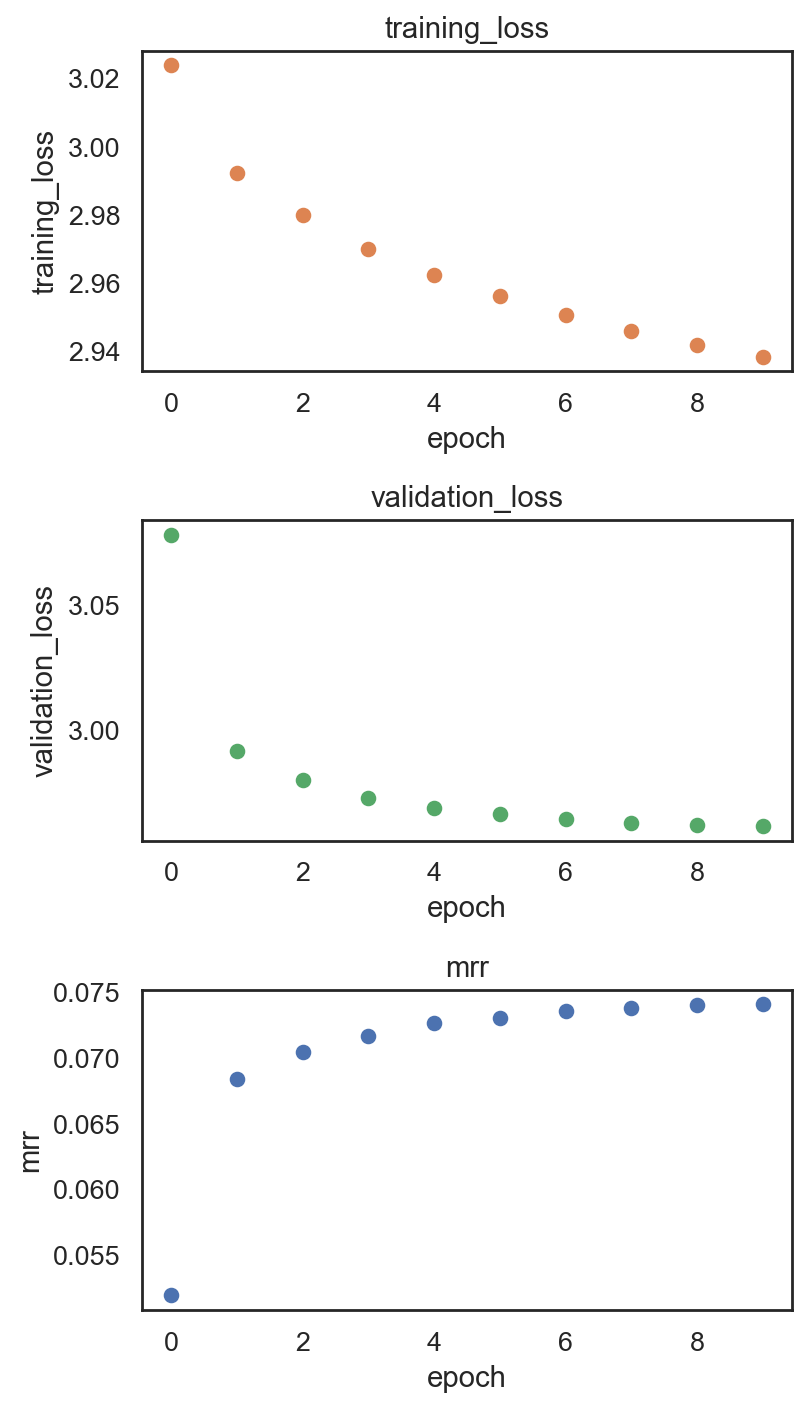

In [27]:
si.pl.pbg_metrics(fig_ncol=1)

### post-training analysis

In [28]:
palette_celltype={'TAC-1':'#F8D856', 'TAC-2':'#F1B044', 'IRS':'#C37777', 
              'Medulla':'#897a74','Hair Shaft-cuticle.cortex':"#d6a780"}

In [27]:
si.settings.pbg_params['checkpoint_path']


'result_multiome_shareseq_v5/pbg/graph_5/model'

In [28]:
dict_adata = si.read_embedding(get_marker_significance=True)

Null feature nodes for entity C not embedded.


In [29]:
dict_adata

{'C': AnnData object with n_obs × n_vars = 6436 × 50,
 'M': AnnData object with n_obs × n_vars = 884 × 50,
 'nM': AnnData object with n_obs × n_vars = 4420 × 50,
 'K': AnnData object with n_obs × n_vars = 884 × 50,
 'nK': AnnData object with n_obs × n_vars = 4420 × 50,
 'G': AnnData object with n_obs × n_vars = 17399 × 50,
 'nG': AnnData object with n_obs × n_vars = 86995 × 50,
 'P': AnnData object with n_obs × n_vars = 332987 × 50,
 'nP': AnnData object with n_obs × n_vars = 332987 × 50}

In [30]:
adata_C = dict_adata['C']  # embeddings for cells
adata_G = dict_adata['G']  # embeddings for genes
adata_P = dict_adata['P']  # embeddings for peaks
adata_K = dict_adata['K']  # embeddings for kmers
adata_M = dict_adata['M']  # embeddings for motifs

#### to distinguish TF motif names from gene names in this case
adata_M.obs.index = 'M_'+adata_M.obs.index

In [31]:
adata_nG = dict_adata['nG']  # embeddings for genes
adata_nP = dict_adata['nP']  # embeddings for peaks
adata_nK = dict_adata['nK']  # embeddings for kmers
adata_nM = dict_adata['nM']  # embeddings for motifs
adata_nM.obs.index = 'M_'+adata_nM.obs.index

In [32]:
adata_C

AnnData object with n_obs × n_vars = 6436 × 50

In [33]:
adata_G

AnnData object with n_obs × n_vars = 17399 × 50

In [34]:
adata_P

AnnData object with n_obs × n_vars = 332987 × 50

In [35]:
adata_K

AnnData object with n_obs × n_vars = 884 × 50

In [36]:
adata_M

AnnData object with n_obs × n_vars = 884 × 50

In [37]:
adata_nG

AnnData object with n_obs × n_vars = 86995 × 50

In [38]:
adata_nP

AnnData object with n_obs × n_vars = 332987 × 50

In [39]:
adata_nK

AnnData object with n_obs × n_vars = 4420 × 50

In [40]:
adata_nM


AnnData object with n_obs × n_vars = 4420 × 50

In [46]:
#some marker genes from the original study
marker_genes = ['Wnt3','Top2a','Shh','Krt27','Foxq1', 'Krt31','Krt71', 'Lef1', 'Hoxc13']

SIMBA metrics

In [41]:
# peaks
adata_cmp_CP = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_P,
                                     adata_query_null=adata_nP)

# genes
adata_cmp_CG = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_G,
                                     adata_query_null=adata_nG)

# motifs
adata_cmp_CM = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_M,
                                     adata_query_null=adata_nM)

# kmers
adata_cmp_CK = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_K,
                                     adata_query_null=adata_nK)

In [57]:
# rename TF motifs and peaks shorter names
import pandas as pd

adata_cmp_CM.var.index = \
pd.Series(adata_cmp_CM.var.index).replace(
    to_replace=['M_ENSMUSG00000027985_LINE1723_Lef1_D', 'M_ENSMUSG00000001655_LINE1151_Hoxc13_D'], 
    value=['TF_Lef1', 'TF_Hoxc13'])
adata_cmp_CP.var.index = \
pd.Series(adata_cmp_CP.var.index).replace(
    to_replace=['chr3_131018470_131018770', 'chr3_131104928_131105228', 'chr3_131177880_131178180', 'chr3_131212270_131212570',
                'chr15_102832980_102833280', 'chr15_102855927_102856227'], 
    value=['Peak1(Lef1)', 'Peak2(Lef1)', 'Peak3(Lef1)', 'Peak4(Lef1)',
           'Peak1(Hoxc13)', 'Peak2(Hoxc13)'])

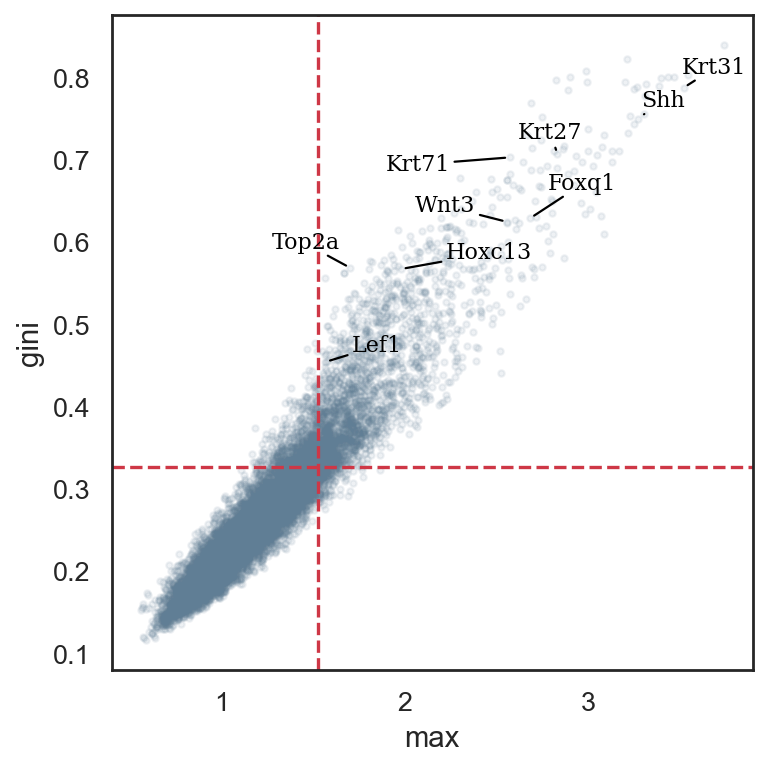

In [47]:
si.pl.entity_metrics(adata_cmp_CG,
                     x='max',
                     y='gini',
                     show_texts=True,
                     cutoff_fdr=0.1,
                     show_cutoff=True,
                     show_contour=False,
                     c='#607e95',
                     texts=marker_genes,
                     text_expand=(2,1.5),
                     alpha=0.1,
                     
                    )

In [55]:
si.pl.entity_metrics(adata_cmp_CG,
                     x='max',
                     y='gini',
                     show_texts=True,
                     cutoff_fdr=0.1,
                     show_cutoff=True,
                     show_contour=False,
                     c='#607e95',
                     texts=marker_genes,
                     text_expand=(2,1.5),
                     alpha=0.1,
                     save_fig=True,
                     fig_name='entity_metrics_genes_fdr0.1.pdf',
                     rasterized=True
                    )

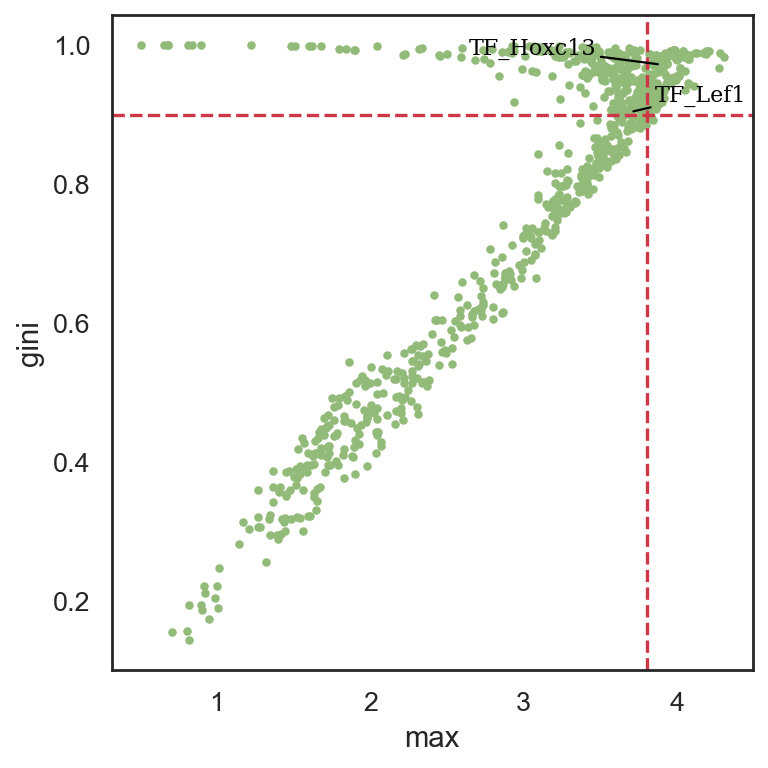

In [49]:
si.pl.entity_metrics(adata_cmp_CM,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=False,
                     cutoff_fdr=0.1,
                     c='#92ba79',
                     texts=['TF_Lef1','TF_Hoxc13'],
                     text_expand=(2,1.5))

In [58]:
si.pl.entity_metrics(adata_cmp_CM,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     show_contour=False,
                     cutoff_fdr=0.1,
                     c='#92ba79',
                     texts=['TF_Lef1','TF_Hoxc13'],
                     text_expand=(2,1.5),
                     save_fig=True,
                     rasterized=True,
                     fig_name='entity_metrics_motifs_fdr0.1.pdf')

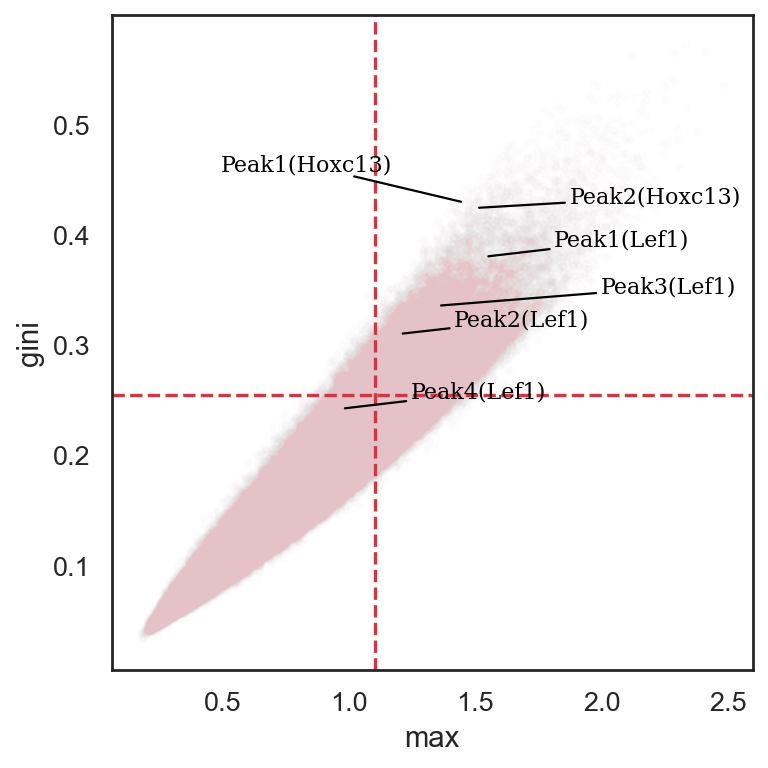

In [59]:
si.pl.entity_metrics(adata_cmp_CP,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     cutoff_fdr=0.1,
                     show_contour=False,
                     texts=['Peak1(Lef1)', 'Peak2(Lef1)', 'Peak3(Lef1)', 'Peak4(Lef1)',
                            'Peak1(Hoxc13)', 'Peak2(Hoxc13)'],
                     text_expand=(2,1.5),
                     alpha=0.02,
                     c='#e5c2c8')

In [60]:
si.pl.entity_metrics(adata_cmp_CP,
                     x='max',
                     y='gini',
                     show_texts=True,
                     show_cutoff=True,
                     cutoff_fdr=0.1,
                     show_contour=False,
                     texts=['Peak1(Lef1)', 'Peak2(Lef1)', 'Peak3(Lef1)', 'Peak4(Lef1)',
                            'Peak1(Hoxc13)', 'Peak2(Hoxc13)'],
                     text_expand=(2,1.5),
                     alpha=0.02,
                     c='#e5c2c8',
                     save_fig=True,
                     fig_name='entity_metrics_peaks_fdr0.1.pdf',
                     rasterized=True
                    )

### save results

In [54]:
# change shorter names back to the orignal names
adata_cmp_CM.var.index = \
pd.Series(adata_cmp_CM.var.index).replace(
    to_replace =['TF_Lef1', 'TF_Hoxc13'],
    value = ['M_ENSMUSG00000027985_LINE1723_Lef1_D', 'M_ENSMUSG00000001655_LINE1151_Hoxc13_D'])
adata_cmp_CP.var.index = \
pd.Series(adata_cmp_CP.var.index).replace(
    to_replace = ['Peak1(Lef1)', 'Peak2(Lef1)', 'Peak3(Lef1)', 'Peak4(Lef1)', 'Peak1(Hoxc13)', 'Peak2(Hoxc13)'],
    value = ['chr3_131018470_131018770', 'chr3_131104928_131105228', 'chr3_131177880_131178180', 'chr3_131212270_131212570',
                'chr15_102832980_102833280', 'chr15_102855927_102856227'])


adata_CG.write(os.path.join(workdir,'adata_CG.h5ad'))
adata_CP.write(os.path.join(workdir,'adata_CP.h5ad'))
adata_PM.write(os.path.join(workdir,'adata_PM.h5ad'))
adata_PK.write(os.path.join(workdir,'adata_PK.h5ad'))

adata_C.write(os.path.join(workdir,'adata_C.h5ad'))
adata_G.write(os.path.join(workdir,'adata_G.h5ad'))
adata_P.write(os.path.join(workdir,'adata_P.h5ad'))
adata_K.write(os.path.join(workdir,'adata_K.h5ad'))
adata_M.write(os.path.join(workdir,'adata_M.h5ad'))

adata_nG.write(os.path.join(workdir,'adata_nG.h5ad'))
adata_nP.write(os.path.join(workdir,'adata_nP.h5ad'))
adata_nK.write(os.path.join(workdir,'adata_nK.h5ad'))
adata_nM.write(os.path.join(workdir,'adata_nM.h5ad'))

adata_cmp_CG.write(os.path.join(workdir,'adata_cmp_CG.h5ad'))
adata_cmp_CM.write(os.path.join(workdir,'adata_cmp_CM.h5ad'))
adata_cmp_CP.write(os.path.join(workdir,'adata_cmp_CP.h5ad'))
adata_cmp_CK.write(os.path.join(workdir,'adata_cmp_CK.h5ad'))